In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from nanonets import Simulation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma

plt.style.use(["science","bright","grid"])

CPU_CNT     = 32
U0_LIST     = np.linspace(0.01,0.05,CPU_CNT,endpoint=False)
N_VOLT      = 50000
TIME_STEP   = 1e-11
PLOT_NORM   = Normalize(vmin=1000*U0_LIST[0], vmax=1000*U0_LIST[-1])
CMAP        = plt.get_cmap('cividis')
FOLDER      = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/size_volt/"
N_PARTICLES = 9

def stretched_exp(t, tau, beta, I0):
    return I0*np.exp(-(t/tau)**beta)

In [111]:
topo    = {"Nx" : 1, "Ny" : 1, "electrode_type" : ['constant','constant']}
sim_c   = Simulation(topo)
tau_t   = 25*sim_c.get_capacitance_matrix()[0][0]*1e6*1e-9 # in ns
print(tau_t)

0.23628021769320412


In [26]:
t   = np.arange(N_VOLT) * TIME_STEP
y   = np.array([pd.read_csv(f"{FOLDER}Nx=9_Ny=9_Ne=8_{V:.5f}.csv")['Observable'].values for V in U0_LIST]).T
y   = np.vstack([np.zeros(len(U0_LIST)),y])
y_e = np.array([pd.read_csv(f"{FOLDER}Nx=9_Ny=9_Ne=8_{V:.5f}.csv")['Error'].values for V in U0_LIST]).T
y_e = np.vstack([np.zeros(len(U0_LIST)),y_e])

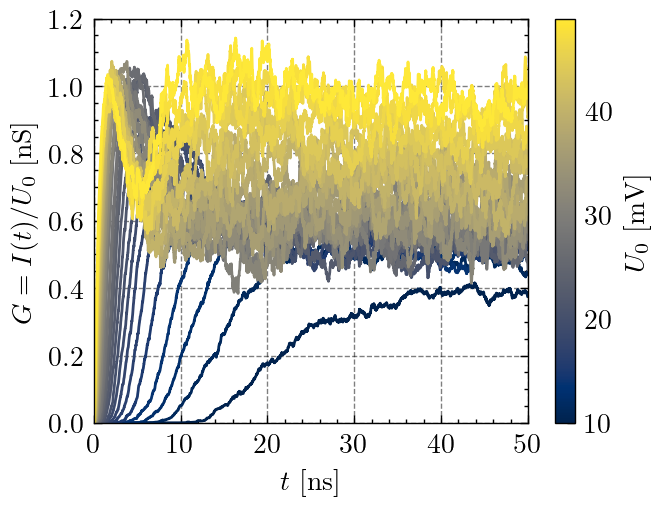

In [118]:
skip    = 0
min_con = 10
sat     = 1000
p_sat   = 0.95
fit_val = []
taus    = []
cvs     = []
fig, ax = plt.subplots(dpi=200)
for i, V in enumerate(U0_LIST[skip:]):

    # Plot Data
    t_copy  = t.copy()*1e9
    y_copy  = (y[:,i+skip].copy()*1e-9)/V
    ye_copy = (y_e[:,i+skip].copy()*1e-9)/V

    ax.plot(t_copy, y_copy, '-', color=CMAP(PLOT_NORM(V*1000)))
    # ax.fill_between(t_copy, y_copy-ye_copy, y_copy+ye_copy, color='grey', alpha=0.5)

    # Get Saturation Values and Transient Part
    sat_mean    = np.median(y_copy[-sat:])

    # threshold crossing: first index where y >= p_sat*sat_mean and persists for min_consec samples
    thresh  = p_sat * sat_mean
    above   = y_copy >= thresh
    # find first run of at least min_consec True
    idx_cut = None
    consec = 0
    for i, val in enumerate(above):
        if val:
            consec += 1
            if consec >= min_con:
                idx_cut = i - (min_con - 1) + 1
                break
        else:
            consec = 0

    # idx_cut     = int(np.where(y_copy>=(p_sat*sat_mean))[0][0])
    t_plot      = t_copy[:idx_cut]
    y_plot      = y_copy[:idx_cut]

    # Get Tau and CV (model-free)
    f       = (sat_mean - y_plot) / sat_mean
    norm    = np.trapz(f, x=t_plot)
    tau     = np.trapz(t_plot * f, x=t_plot) / norm
    tau2    = np.trapz(t_plot**2 * f, x=t_plot) / norm
    sigma   = np.sqrt(tau2 - tau**2)
    cv      = sigma / tau

    # Append
    taus.append(tau)
    cvs.append(cv)

_ = ax.set_xlabel("$t$ [ns]")
_ = ax.set_ylabel("$G = I(t)/U_0$ [nS]")
_ = ax.set_xlim(0, 5000*TIME_STEP*1e9)
_ = ax.set_ylim(0, 1.2)
sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

fig.savefig(f"plots/png/DC/N={N_PARTICLES}_N={N_PARTICLES}_G_vs_t.png", transparent=False)
fig.savefig(f"plots/pdf/DC/N={N_PARTICLES}_N={N_PARTICLES}_G_vs_t.pdf", transparent=False)
fig.savefig(f"plots/svg/DC/N={N_PARTICLES}_N={N_PARTICLES}_G_vs_t.svg", transparent=True)

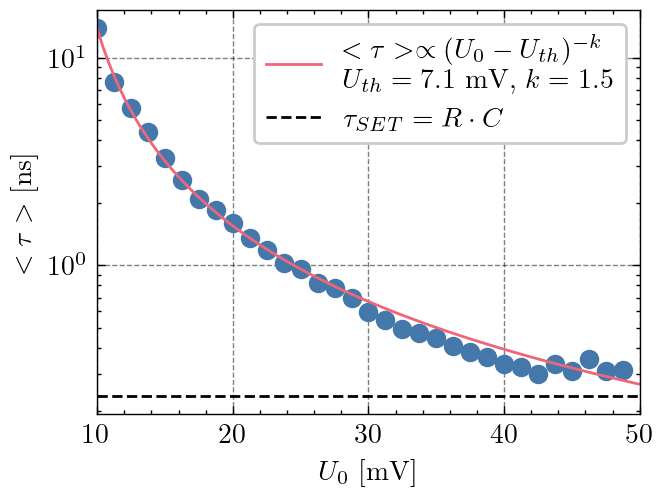

In [112]:
def power_law1(x, A, k, tau0):
    return tau0 + A*x**(-k)
def power_law2(x, A, k, V_th):
    return A*(x-V_th)**(-k)
def power_law3(x, A, k, tau0, V_th):
    return tau0 + A*(x-V_th)**(-k)

V_write     = np.array(U0_LIST[skip:])*1000
V_clean     = V_write[V_write < 40]
tau_clean   = np.array(taus)[V_write < 40]
p, cov      = curve_fit(power_law2, V_clean, tau_clean, bounds=[[0,0,0],[np.inf,np.inf,10]])
V_fit       = np.linspace(10, 50, 100)
tau_fit     = power_law2(V_fit, *p)

fig, ax = plt.subplots(dpi=200)
_ = ax.plot(np.array(U0_LIST[skip:])*1000, taus, 'o')#, label='$<\\tau> = \\frac{\\tau_K}{\\beta}\\Gamma(\\frac{1}{\\beta})$')
_ = ax.plot(V_fit, tau_fit, label='$<\\tau>\\propto (U_0 - U_{th})^{-k}$\n$U_{th} = '+f'{p[2].round(1)}$ mV, $k = {p[1].round(1)}$')
_ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
_ = ax.legend()
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$<\\tau>$ [ns]")
_ = ax.set_xlim(10, 50)
_ = ax.set_yscale('log')

fig.savefig(f"plots/png/DC/N={N_PARTICLES}_N={N_PARTICLES}_tau_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/DC/N={N_PARTICLES}_N={N_PARTICLES}_tau_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/DC/N={N_PARTICLES}_N={N_PARTICLES}_tau_vs_U.svg", transparent=True)

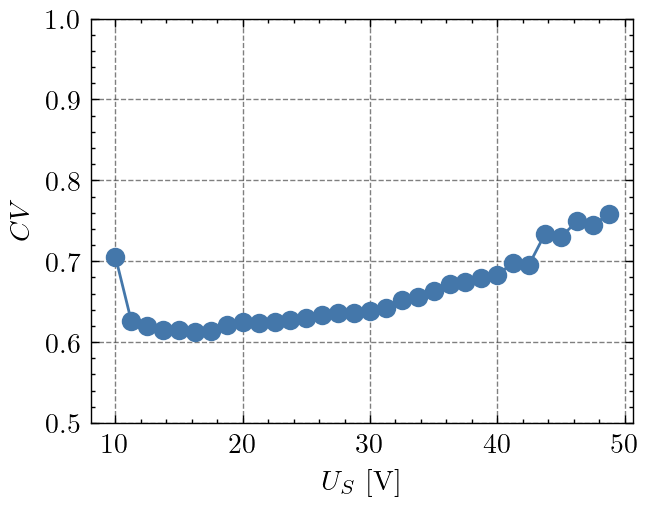

In [107]:
fig, ax = plt.subplots(dpi=200)
_ = ax.plot(np.array(U0_LIST[skip:])*1000, cvs, '-o')
_ = ax.set_xlabel("$U_S$ [V]")
_ = ax.set_ylabel("$CV$")
_ = ax.set_ylim(0.5,1.)